In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

%cd '../jmeter/'

/Users/quby/Github/What-A-Capacity-Test/jmeter


In [2]:
def load_experiment(folder):
  """
  Load experiment data from different csv and manipulate to order and add usefull info
  """
  # All experiment will be loaded in array with a pandas dataframe for each test
  data = []

  # Load all files from folder
  files = glob.glob('./' + folder + '/*.csv')
  
  for i, csv in enumerate(files):
    data.append(pd.read_csv(csv))
    
    # Data will be ordered by timeStamp
    data[i].sort_values("timeStamp", inplace=True)
    data[i].reset_index(inplace=True)

    # Recalculate timeStamp using first response as time base
    data[i]["timeStamp"] = (data[i]["timeStamp"] - data[i]["timeStamp"][0]) / 1000
    
    # Define new columns with number of success and errors at current row
    data[i]["Errors"] = data[i]["ErrorCount"].cumsum()
    data[i]["Success"] = data[i].index - data[i]["Errors"]

    # Define Throughput Column
    data[i]["Throughput"] = data[i]["Success"] / data[i]["timeStamp"]

  return data

# Capacity Test Dynamic



Considering previous results, capacity test will be performed on a dynamic workload's configuration. Analist decided based on the previous results, to test the configuration #3:

- Apache CPU: 0.125 vCPU (Level 1)
- Apache RAM: 256MB RAM (Level 1)
- MariaDB CPU: 0.5 vCPU (Level 2)
- MariaDB RAM: 1GB RAM (Level 2)


In [3]:
experiment = load_experiment('experiment_3')

## Data Visualization

Performance analysis can be characterized by several indicators, in this case will be studied those indicators:

| Indicator | Description |
| --------- | ----------- |
| *Response Rate (Throughput)* | The **number of requests** per second that the application can handle. |
| *Elapsed Time* | The time it takes for the server to **handle** a request. |
| *Latency* | The time it takes for the server to **respond** to a request. |
| *Requests Failed* | The number of requests that **failed**. |

[]

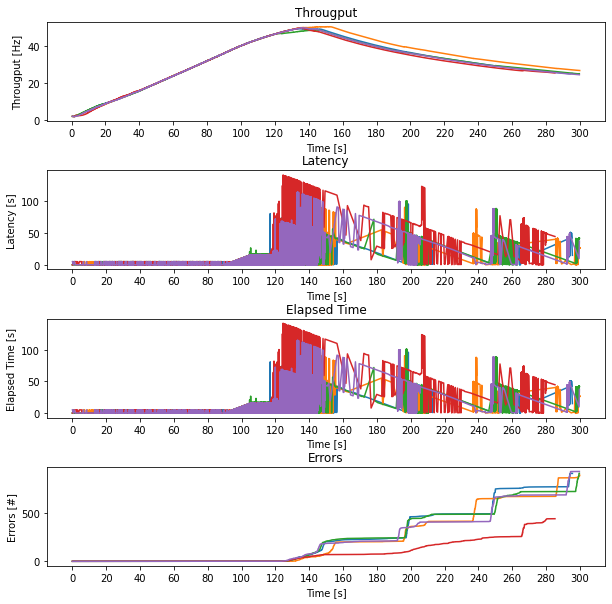

In [4]:
fig, axs = plt.subplots(4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

for test in range(5):

    axs[0].set_title("Througput")
    axs[0].set_xlabel("Time [s]")
    axs[0].set_ylabel("Througput [Hz]")
    axs[0].set_xticks(np.arange(0, 301, step=20))
    axs[0].plot(experiment[test]["timeStamp"], experiment[test]["Throughput"])

    axs[1].set_title("Latency")
    axs[1].set_xlabel("Time [s]")
    axs[1].set_ylabel("Latency [s]")
    axs[1].set_xticks(np.arange(0, 301, step=20))
    axs[1].plot(experiment[test]["timeStamp"], experiment[test]["Latency"]/1000)

    axs[2].set_title("Elapsed Time")
    axs[2].set_xlabel("Time [s]")
    axs[2].set_ylabel("Elapsed Time [s]")
    axs[2].set_xticks(np.arange(0, 301, step=20))
    axs[2].plot(experiment[test]["timeStamp"], experiment[test]["elapsed"]/1000)

    axs[3].set_title("Errors")
    axs[3].set_xlabel("Time [s]")
    axs[3].set_ylabel("Errors [#]")
    axs[3].set_xticks(np.arange(0, 301, step=20))
    axs[3].plot(experiment[test]["timeStamp"], experiment[test]["Errors"])

plt.plot()

Visualization of all experiments results could be noisly, so mean of indicators will be plotted instead.

[]

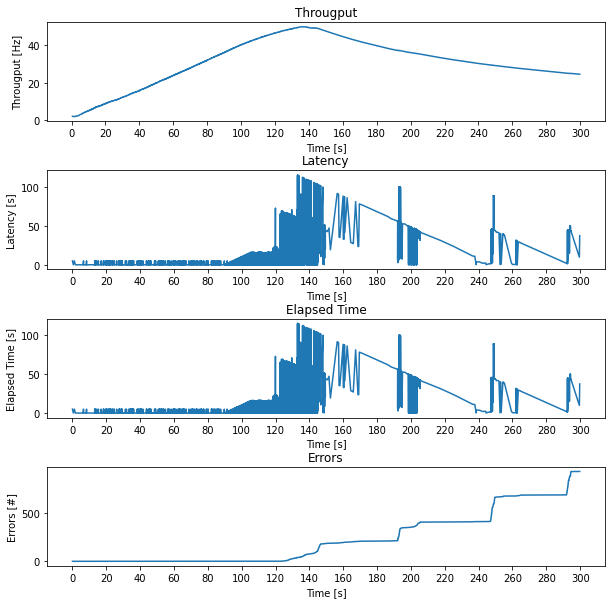

In [5]:
timestamp = np.array([experiment[test]["timeStamp"] for x in range(5)]).mean(axis=0)
throughput = np.array([experiment[test]["Throughput"] for x in range(5)]).mean(axis=0)
latency = np.array([experiment[test]["Latency"] for x in range(5)]).mean(axis=0)
elapsed = np.array([experiment[test]["elapsed"] for x in range(5)]).mean(axis=0)
errors = np.array([experiment[test]["Errors"] for x in range(5)]).mean(axis=0)

fig, axs = plt.subplots(4, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)

axs[0].set_title("Througput")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Througput [Hz]")
axs[0].set_xticks(np.arange(0, 301, step=20))
axs[0].plot(timestamp, throughput)

axs[1].set_title("Latency")
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel("Latency [s]")
axs[1].set_xticks(np.arange(0, 301, step=20))
axs[1].plot(timestamp, latency/1000)

axs[2].set_title("Elapsed Time")
axs[2].set_xlabel("Time [s]")
axs[2].set_ylabel("Elapsed Time [s]")
axs[2].set_xticks(np.arange(0, 301, step=20))
axs[2].plot(timestamp, elapsed/1000)

axs[3].set_title("Errors")
axs[3].set_xlabel("Time [s]")
axs[3].set_ylabel("Errors [#]")
axs[3].set_xticks(np.arange(0, 301, step=20))
axs[3].plot(timestamp, errors)

plt.plot()


As shown in the figure, latency and elapsed have a similar behavior, that because of the nature of the workload, infact too much SQL requests led to MariaDB component to crash and recovery phase is not fast enough to handle the workload.

## Capacity Point

**Knee Capacity** is the point beyond which the response time increases rapidly as the load but the gain in throughput is small. Before the knee, the response time does not increase significantly but the throughput rises as the load increases.

**Usable Capacity** is the point of maximum throughput achievable without exceeding a prespecified response time limit.

### Knee Capacity

In this case knee and usable capacity are very close, so it is a good practice to choose a smaller knee capacity to dimensionate the workload: analist decided to individuate the knee point as the point at 100 seconds of workload.

In [6]:
knee_point = 100
ramp_up = 150
virtual_users = 250

knee_users = (knee_point / ramp_up) * virtual_users
knee_users

166.66666666666666

So the system is able to handle about 160 users that perform requests contemporaneously on a database without any problem.

### Usable Capacity

Usable Point is individuated when throughput stop to increase and system start to return errors due to component crash: analist decide to individuate the usable point as the point at 140 seconds of workload.

In [7]:
usable_point = 140

usable_users = (usable_point / ramp_up) * virtual_users
usable_users

233.33333333333334

So the system is able to handle about 230 users that perform requests contemporaneously on a database at maximum.